In [68]:
using Unitful, UnitfulRecipes           # Unidades físicas
using FFTW                              # Transformadas de Fourier
using Plots, PlotThemes, ColorSchemes   # Gráficos
using Trapz                             # Integral numérica

import PhysicalConstants.CODATA2014: c_0
c = c_0 |> u"km/ps"

theme(:juno)
default(size=(800,400), linewidth=2, palette=:seaborn_deep6)

Al igual que en el problema anterior, adaptamos las funciones `fft`, `ifft`, y `trapz` para que admitan valores con unidades.

In [69]:
function ufft(y, dim=1)
    yval, yunit = ustrip.(y), unit(y[1])
    return fft(yval, dim)*yunit
end
function uifft(y, dim=1)
    yval, yunit = ustrip.(y), unit(y[1])
    return ifft(yval, dim)*yunit
end
function utrapz(x, y)
    xval, xunit = ustrip.(x), unit(x[1])
    yval, yunit = ustrip.(y), unit(y[1])
    return trapz(xval, yval)*yunit*xunit
end 

utrapz (generic function with 1 method)

Definimos la función `fwhm` que calcula el ancho de un pulso con definición full width at half maximum

In [70]:
function fwhm(x, y)
    maxy = maximum(y)
    n1 = findfirst(a -> a>maxy/2, y)
    n2 = findlast(a -> a>maxy/2, y)
    return x[n2]-x[n1]
end

fwhm (generic function with 1 method)

También la función `power` que calcula la potencia de un pulso, y `normalize`, que la usa para forzar el teorema de Parseval sobre un par transformado por FFT.

In [71]:
power(x, y) = utrapz(x, abs.(y).^2)

normalize(x, Ax, y, Ay) = Ay*sqrt(power(x, Ax)/power(y, Ay))

normalize (generic function with 1 method)

Ya que vamos a trabajar con más de un tipo de fibra, definimos un tipo de dato que represente los specs relevantes de una fibra óptica. 

In [72]:
struct Fibra γ; α; end

SMF = Fibra(1.2u"W^(-1)*km^(-1)", uconvertp(NoUnits,0.02u"dB")*u"km^-1") 
NZ_DSF = Fibra(1.8u"W^(-1)*km^(-1)", uconvertp(NoUnits,0.22u"dB")*u"km^-1")

Fibra(1.8 km^-1 W^-1, 1.0519618738232228 km^-1)

Elegimos el número de puntos en el que vamos a discretizar el dominio, y elegimos propagar un pulso de ancho de $10\,\text{ps}$. Definimos el vector $z$ de $0$ a $80 \, \text{km}$

In [73]:
N = 512

T0 = 10u"ps"
B0 = 1/(2π*T0) |> u"GHz"

z = range(0u"km", 80u"km", N)

(0.0:0.15655577299412915:80.0) km

Elegimos la fibra SMF y un pulso con potencia de $1\,\text{mW}$. En función de esto calculamos la longitud característica de no-linealidad $L_{NL}$ y la de atenuación $L_{eff}$

In [74]:
fibra = SMF
P0 = 10u"mW"

Leff = 1/fibra.α
LNL = 1/(fibra.γ*P0) |> u"km"

println("Longitud característica de atenuación = $Leff\nLongitud característica de no-lineal. = $LNL")

Longitud característica de atenuación = 0.9954054173515269 km
Longitud característica de no-lineal. = 83.33333333333333 km


Definimos un vector de frecuencias en función del ancho final del espectro en el caso con más SPM (máximo $\gamma$, máximo $P_0$), y el vector de tiempo en función de la resolución del vector de frecuencias. Sobre ese vector de tiempo definimos el pulso gaussiano de potencia $P_0$

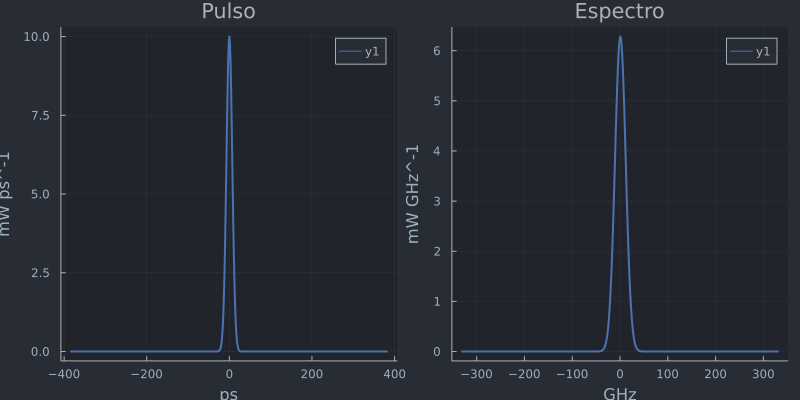

In [75]:
ϕmax = NZ_DSF.γ*100u"mW"*z[end]
Bf = sqrt(1+4/(3*sqrt(3))*ϕmax)*B0

f = range(-6*Bf, 6*Bf, N)

Δt = 1/(f[2]-f[1]) |> u"ps"
t = fftfreq(N, Δt) |> fftshift;

At0 = sqrt(P0/u"ps")*exp.(-t.^2/(2T0^2))
Af0 = ufft(At0) |> fftshift
Af0 = normalize(t, At0, f, Af0)

p1 = plot(t, At0.^2, title="Pulso")
p2 = plot(f, abs.(Af0).^2, title="Espectro")
plot(p1, p2)

Definimos una grilla de coordenadas discretas $(i,\, j)$ en donde vamos a evaluar el problema. Esta grilla se va a usar tanto para indexar coordenadas $(z,\, t)$ como $(z,\, f)$.

In [76]:
ij = Iterators.product(1:N, 1:N) |> collect;

Para para calcular la evolución del espectro a lo largo de la fibra, usamos el resultado  
$$A(z,t) = A(0, t) \exp\left[i\gamma \lvert A(z,0)\rvert^2z\right] \longrightarrow A_t[i, j] = A_{t0}[j]\exp\left[i\gamma \lvert A_{t0}[j]\rvert^2z_i\right]$$

In [77]:
A((i, j)) = At0[j]*exp(im*fibra.γ*abs(At0[j])^2*1u"ps"*z[i])

A (generic function with 1 method)

Evaluamos $A_t[i,j]$ en los puntos $(i,\, j) \leftrightarrow(z,\, t)$. Transformamos Fourier a lo largo de la dimensión $j$ para obtener el resultado $A_f[i,j]$ en el dominio $(i,\, j) \leftrightarrow(z,\, f)$

In [78]:
At = A.(ij)
Af = ufft(At, 2)
Af = fftshift(Af, 2)

Af = hcat([normalize(t, At, f, Af) for (Af, At) in zip(eachrow(Af), eachrow(At))]...)';

Visualizamos la evolución de la forma del pulso y del espectro en forma _heatmap_

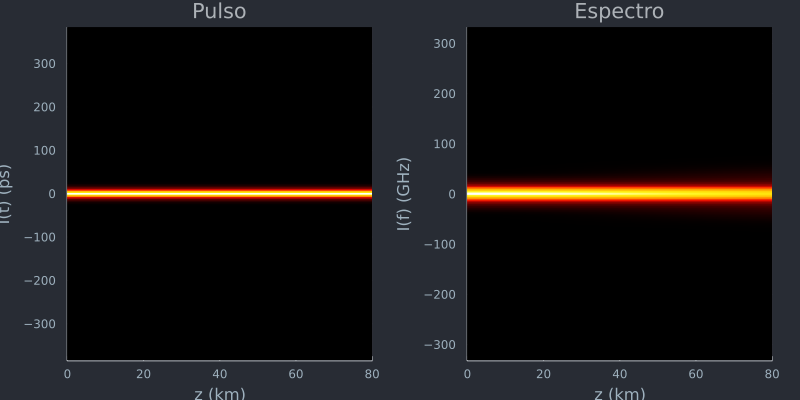

In [79]:
function heatmap_pulse(z, t, At, f, Af)
    p1 = heatmap(z, t, abs.(At').^2, xlabel="z", ylabel="I(t)", title="Pulso")
    p2 = heatmap(z, f, abs.(Af').^2, xlabel="z", ylabel="I(f)", title="Espectro")
    plot(p1, p2, layout=(1,2), colorbar=false, zaxis=:log)
end

heatmap_pulse(z, t, At, f, Af)

Y también con una animación que muestra la forma del pulso mientras este se propaga a través de la fibra

┌ Info: Saved animation to 
│   fn = /tmp/jl_R8ABeA.gif
└ @ Plots /home/inox/.julia/packages/Plots/1KWPG/src/animation.jl:114


Plots.AnimatedGif("/tmp/jl_R8ABeA.gif")
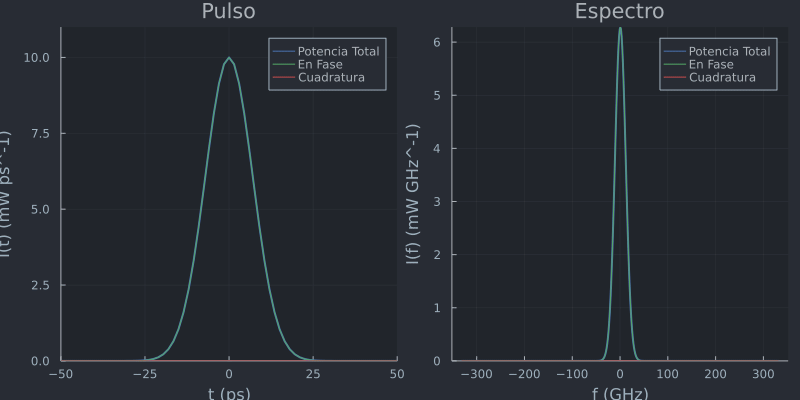

In [80]:
function animate_pulse(t, At, f, Af)
    ylimsf = (0*unit(Af[1])^2, maximum(abs.(Af).^2))
    ylimst = (0*unit(At[1])^2, maximum(abs.(At).^2)).*1.1
    xlimst = (-5*T0, 5*T0)

    @gif for i in 1:N   
        p2 = plot(f, abs.(Af[i,:]).^2, linewidth=2, ylims=ylimsf, label="Potencia Total", xlabel = "f", ylabel = "I(f)", title="Espectro")
        plot!(f, real(Af[i,:]).^2, label="En Fase", linewidth=1); 
        plot!(f, imag(Af[i,:]).^2, label="Cuadratura", linewidth=1)

        p1 = plot(t, abs.(At[i,:]).^2, linewidth=2, xlims=xlimst, ylims=ylimst, label="Potencia Total", xlabel = "t", ylabel = "I(t)", title="Pulso")
        plot!(t, real(At[i,:]).^2, label="En Fase", linewidth=1); 
        plot!(t, imag(At[i,:]).^2, label="Cuadratura", linewidth=1)
        plot(p1, p2, layout=(1,2))
    end every 8
end

animate_pulse(t, At, f, Af)

Ahora consideramos el efecto de la atenuación, usamos el resultado

$$A(z,t) = A(0, t) \exp\left[i\gamma \lvert A(z,0)\rvert^2z_{eff}\right] \longrightarrow A_t[i, j] = A_{t0}[j]\exp\left[i\gamma \lvert A_{t0}[j]\rvert^2z_{eff}[i]\right]$$
Donde la longitud efectiva es: $z_{eff} = \dfrac{1-e^{-\alpha z}} \alpha$

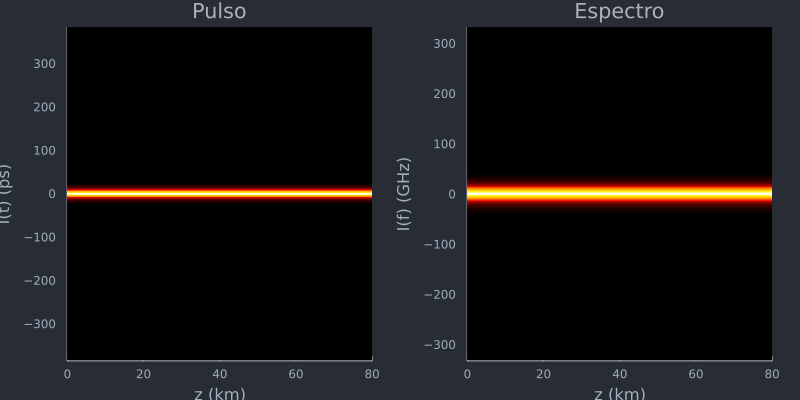

In [81]:
function A_att((i, j))
    zeff = (1-exp(-fibra.α*z[i]))/fibra.α
    return At0[j]*exp(im*fibra.γ*abs(At0[j])^2*1u"ps"*zeff)
end

At = A_att.(ij)
Af = ufft(At, 2)
Af = fftshift(Af, 2)
Af = hcat([normalize(t, At, f, Af) for (Af, At) in zip(eachrow(Af), eachrow(At))]...)'

heatmap_pulse(z, t, At, f, Af)

┌ Info: Saved animation to 
│   fn = /tmp/jl_q9aoLH.gif
└ @ Plots /home/inox/.julia/packages/Plots/1KWPG/src/animation.jl:114


Plots.AnimatedGif("/tmp/jl_q9aoLH.gif")
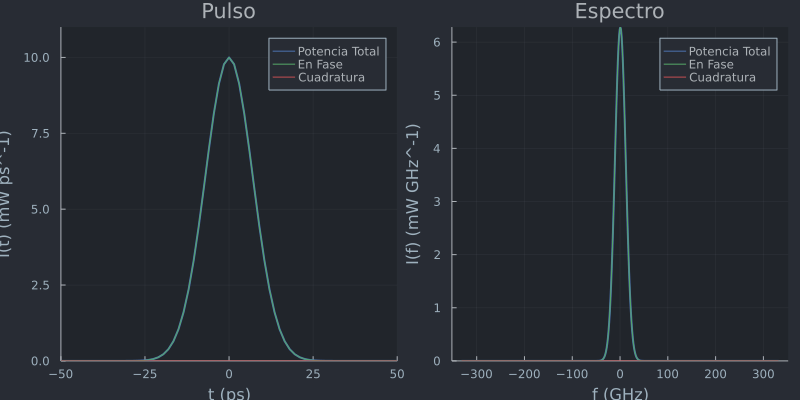

In [82]:
animate_pulse(t, At, f, Af)

Repetimos el análisis incrementando la potencia del pulso a $100\, \text{mW}$

In [83]:
fibra = SMF
P0 = 100u"mW"
At0 = sqrt(P0/u"ps")*exp.(-t.^2/(2T0^2))

Leff = 1/fibra.α
LNL = 1/(fibra.γ*P0) |> u"km"

println("Longitud característica de atenuación = $Leff\nLongitud característica de no-lineal. = $LNL")

Longitud característica de atenuación = 0.9954054173515269 km
Longitud característica de no-lineal. = 8.333333333333334 km


Primero sin atenuación:

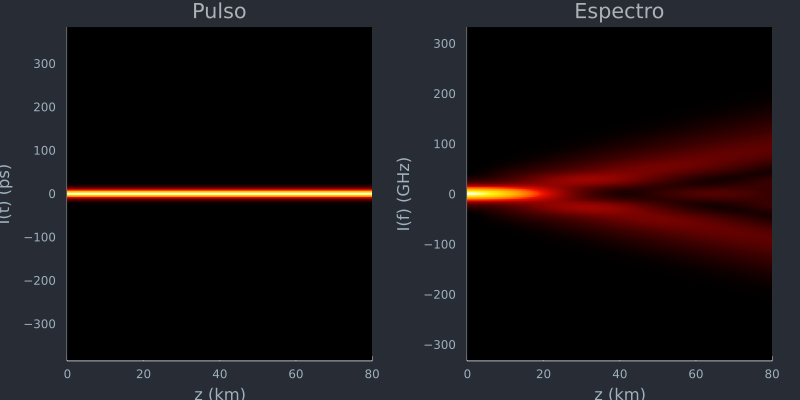

In [84]:
At = A.(ij)
Af = ufft(At, 2)
Af = fftshift(Af, 2)
Af = hcat([normalize(t, At, f, Af) for (Af, At) in zip(eachrow(Af), eachrow(At))]...)'

heatmap_pulse(z, t, At, f, Af)

┌ Info: Saved animation to 
│   fn = /tmp/jl_qTRm3X.gif
└ @ Plots /home/inox/.julia/packages/Plots/1KWPG/src/animation.jl:114


Plots.AnimatedGif("/tmp/jl_qTRm3X.gif")
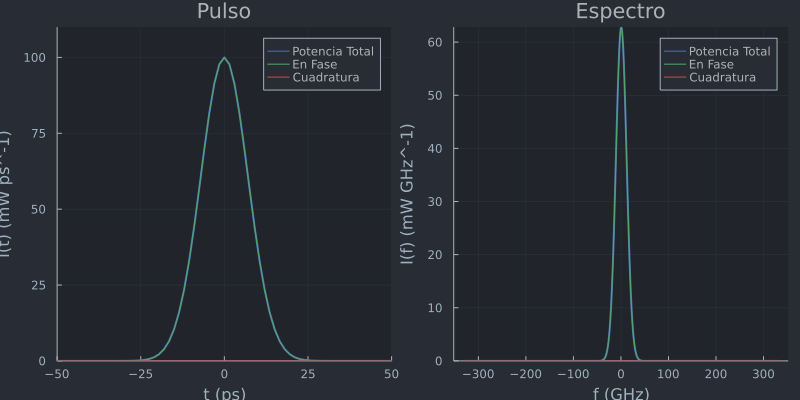

In [85]:
animate_pulse(t, At, f, Af)

Ya que en este ejemplo se puede apreciar visualmente el ensanchamiento del espectro, comparemos el valor medido con el valor teórico dado por

$$\frac {\Delta w} {\Delta w_0} = \sqrt{1+\frac 1 {3 \sqrt 3}\phi_{max}^2} \qquad \qquad \phi_{max}=\gamma P_0 z_{eff}$$

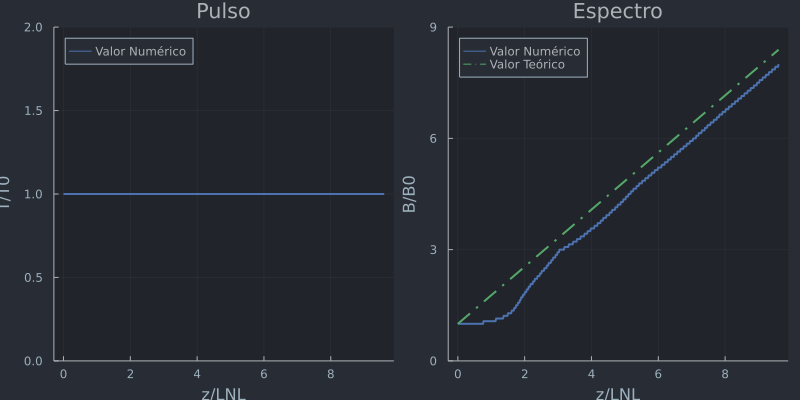

In [86]:
ϕmax_fun(z) = fibra.γ*P0*z
Bf_fun(z) = 1+4/(3*sqrt(3))*ϕmax_fun(z)

pw = [fwhm(t, abs.(A)) for A in eachrow(At)]
bw = [fwhm(f, abs.(A)) for A in eachrow(Af)]

pw = pw./pw[1]
bw = bw./bw[1]

p1 = plot(z/LNL, pw, xlabel="z/LNL", ylabel="T/T0", ylims=(0, maximum(pw)*1.1 |> ceil), title="Pulso"; label="Valor Numérico")
p2 = plot(z/LNL, bw, xlabel="z/LNL", ylabel="B/B0", ylims=(0, maximum(bw)*1.1 |> ceil), title="Espectro", label="Valor Numérico")
plot!(p2, z/LNL, Bf_fun.(z), linestyle=:dashdot, label="Valor Teórico")

plot(p1, p2, legend=:topleft)

Luego con atenuación:

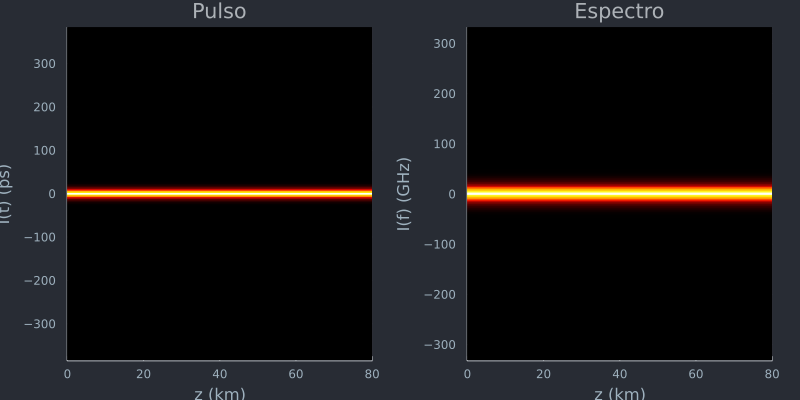

In [87]:
At = A_att.(ij)
Af = ufft(At, 2)
Af = fftshift(Af, 2)
Af = hcat([normalize(t, At, f, Af) for (Af, At) in zip(eachrow(Af), eachrow(At))]...)'

heatmap_pulse(z, t, At, f, Af)

┌ Info: Saved animation to 
│   fn = /tmp/jl_YeK5Sl.gif
└ @ Plots /home/inox/.julia/packages/Plots/1KWPG/src/animation.jl:114


Plots.AnimatedGif("/tmp/jl_YeK5Sl.gif")
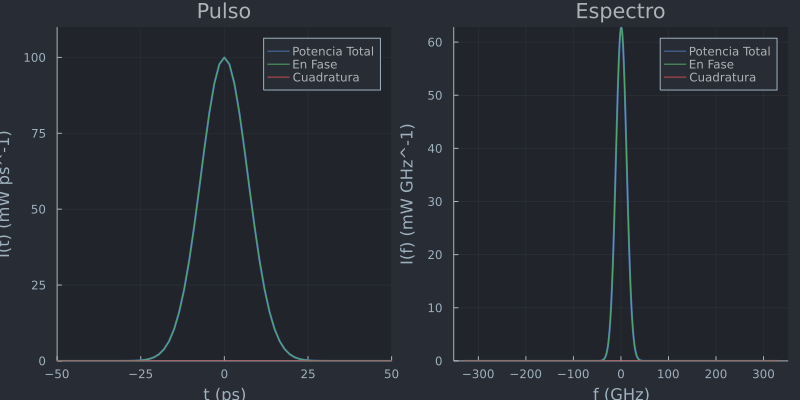

In [88]:
animate_pulse(t, At, f, Af)

Ahora con la fibra TW-RS, primero con un pulso de $10\,\text{mW}$, sin atenuación

In [89]:
fibra = NZ_DSF
P0 = 10u"mW"
At0 = sqrt(P0/u"ps")*exp.(-t.^2/(2T0^2))

Leff = 1/fibra.α
LNL = 1/(fibra.γ*P0) |> u"km"

println("Longitud característica de atenuación = $Leff\nLongitud característica de no-lineal. = $LNL")

Longitud característica de atenuación = 0.9506047936562816 km
Longitud característica de no-lineal. = 55.55555555555555 km


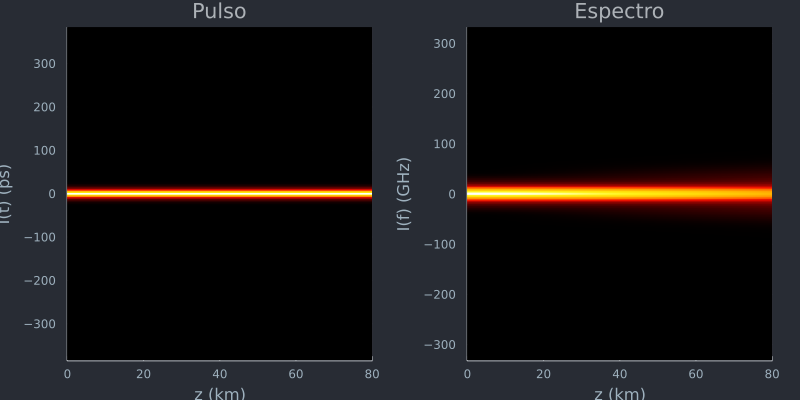

In [90]:
At = A.(ij)
Af = ufft(At, 2)
Af = fftshift(Af, 2)
Af = hcat([normalize(t, At, f, Af) for (Af, At) in zip(eachrow(Af), eachrow(At))]...)'

heatmap_pulse(z, t, At, f, Af)

┌ Info: Saved animation to 
│   fn = /tmp/jl_ZHKLzH.gif
└ @ Plots /home/inox/.julia/packages/Plots/1KWPG/src/animation.jl:114


Plots.AnimatedGif("/tmp/jl_ZHKLzH.gif")
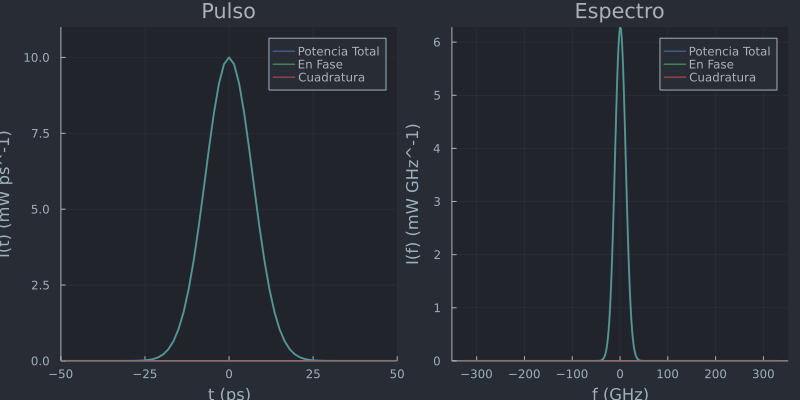

In [91]:
animate_pulse(t, At, f, Af)

Y con atenuación

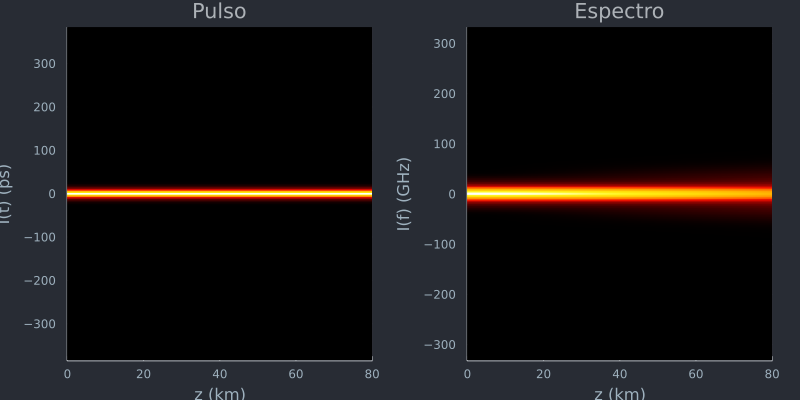

In [92]:
At = A.(ij)
Af = ufft(At, 2)
Af = fftshift(Af, 2)
Af = hcat([normalize(t, At, f, Af) for (Af, At) in zip(eachrow(Af), eachrow(At))]...)'

heatmap_pulse(z, t, At, f, Af)

┌ Info: Saved animation to 
│   fn = /tmp/jl_rug6Qg.gif
└ @ Plots /home/inox/.julia/packages/Plots/1KWPG/src/animation.jl:114


Plots.AnimatedGif("/tmp/jl_rug6Qg.gif")
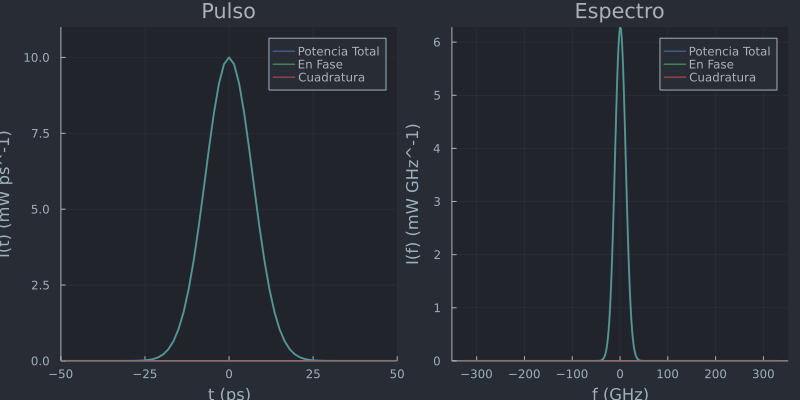

In [93]:
animate_pulse(t, At, f, Af)

Finalmente la fibra TW-RS con un pulso de $100\,\text{mW}$, sin atenuación

In [94]:
fibra = NZ_DSF
P0 = 100u"mW"
At0 = sqrt(P0/u"ps")*exp.(-t.^2/(2T0^2))

Leff = 1/fibra.α
LNL = 1/(fibra.γ*P0) |> u"km"

println("Longitud característica de atenuación = $Leff\nLongitud característica de no-lineal. = $LNL")

Longitud característica de atenuación = 0.9506047936562816 km
Longitud característica de no-lineal. = 5.555555555555555 km


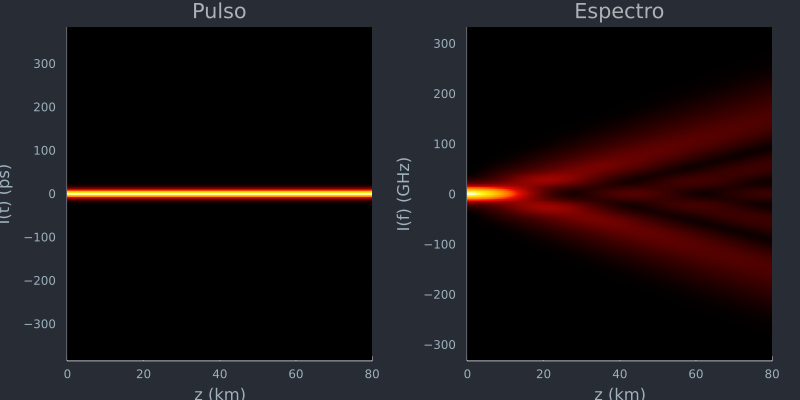

In [95]:
At = A.(ij)
Af = ufft(At, 2)
Af = fftshift(Af, 2)
Af = hcat([normalize(t, At, f, Af) for (Af, At) in zip(eachrow(Af), eachrow(At))]...)'

heatmap_pulse(z, t, At, f, Af)

┌ Info: Saved animation to 
│   fn = /tmp/jl_CobwbU.gif
└ @ Plots /home/inox/.julia/packages/Plots/1KWPG/src/animation.jl:114


Plots.AnimatedGif("/tmp/jl_CobwbU.gif")
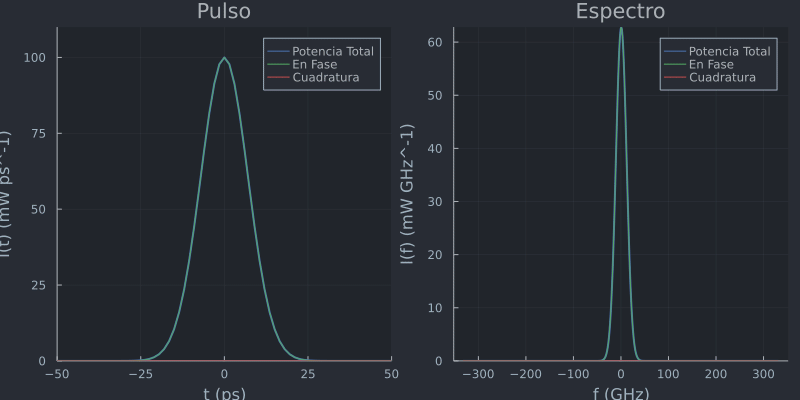

In [96]:
animate_pulse(t, At, f, Af)

Vemos nuevamente el ensanchamiento del espectro

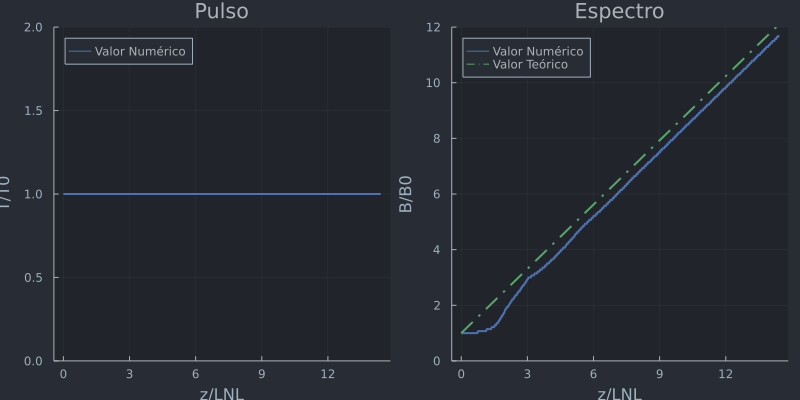

In [97]:
pw = [fwhm(t, abs.(A)) for A in eachrow(At)]
bw = [fwhm(f, abs.(A)) for A in eachrow(Af)]

pw = pw./pw[1]
bw = bw./bw[1]

p1 = plot(z/LNL, pw, xlabel="z/LNL", ylabel="T/T0", ylims=(0, maximum(pw)*1.1 |> ceil), title="Pulso"; label="Valor Numérico")
p2 = plot(z/LNL, bw, xlabel="z/LNL", ylabel="B/B0", ylims=(0, maximum(bw) |> ceil), title="Espectro", label="Valor Numérico")
plot!(p2, z/LNL, Bf_fun.(z), linestyle=:dashdot, label="Valor Teórico")

plot(p1, p2, legend=:topleft)

Y con atenuación

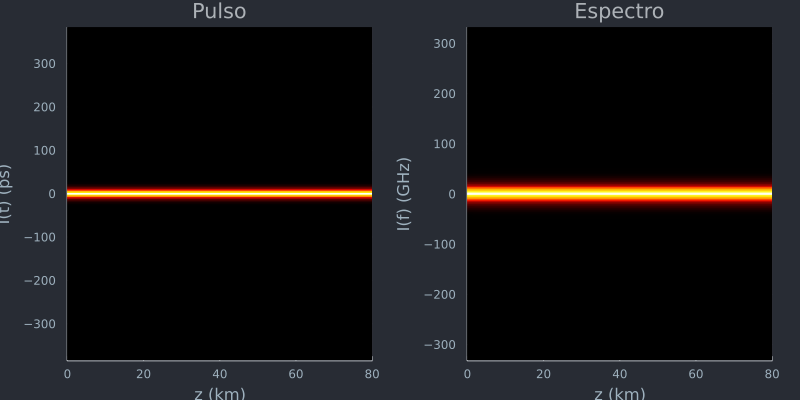

In [98]:
At = A_att.(ij)
Af = ufft(At, 2)
Af = fftshift(Af, 2);
Af = hcat([normalize(t, At, f, Af) for (Af, At) in zip(eachrow(Af), eachrow(At))]...)'

heatmap_pulse(z, t, At, f, Af)

┌ Info: Saved animation to 
│   fn = /tmp/jl_DKh9eJ.gif
└ @ Plots /home/inox/.julia/packages/Plots/1KWPG/src/animation.jl:114


Plots.AnimatedGif("/tmp/jl_DKh9eJ.gif")
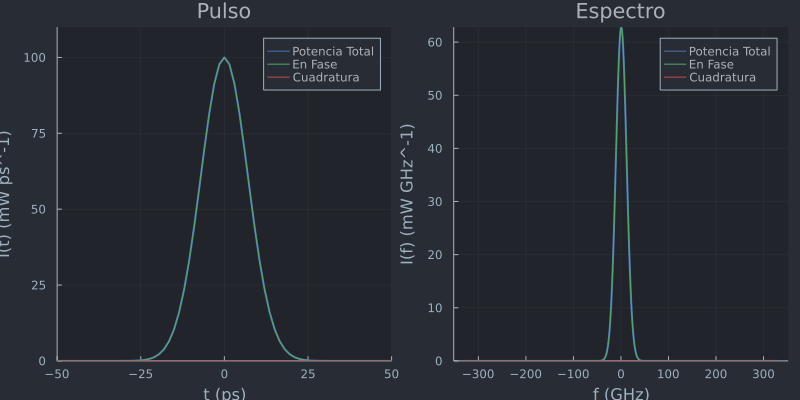

In [99]:
animate_pulse(t, At, f, Af)

En todos los casos se ve que la atenuación efectivamente mata a la SPM muy rápidamente, para estos valores de $\alpha$ y $\gamma$